# Design Single Country Nat Cat Bonds

In [1]:
#import generald packages
import numpy as np

#import climada stuff
from climada.hazard import tc_tracks, Centroids, TropCyclone
from climada.entity import LitPop
from climada.util.api_client import Client
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.engine import ImpactCalc
import functions as fct


client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


### Load TC Tracks

In [2]:
basins = ['EP','NA','NI','SI','SP','WP']

storms_basin = fct.init_STORM_tracks(basins=basins)

Starting function
Loaded storms for basin NA
Combined storms for basin NA
Number of tracks in NA basin: 107063


### Generate Exposure Data 
    a) Generate exposure data using newest available data by myself. Can choose fin_mode myself. <br>
    b) Download readily calculated exposure data using the Data API from CLIMADA. Exposure is based on data from 2014 and based on fin_mode produced capital. Exponents = 1,1; 30arcsec grid 

<GeoAxes: title={'center': "LitPop Exposure for ['fji'] at 300 as, year: 2020, financial mode:\ngdp, exp: (1, 1), admin1_calc: False"}>

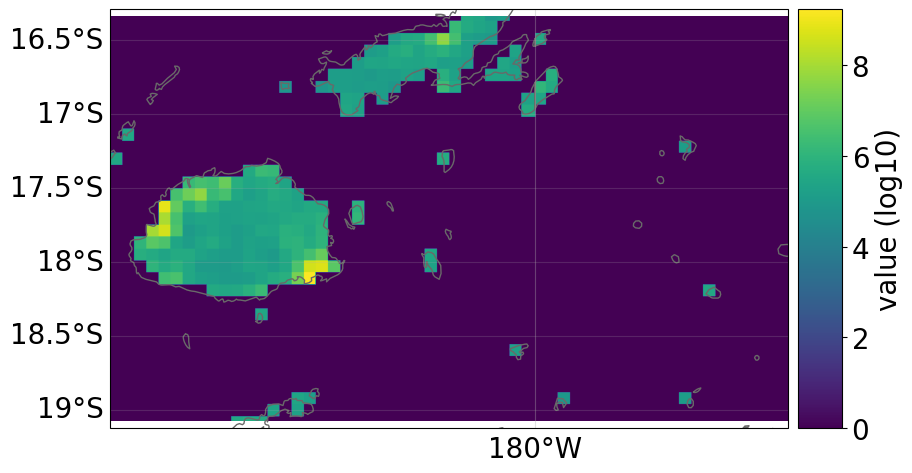

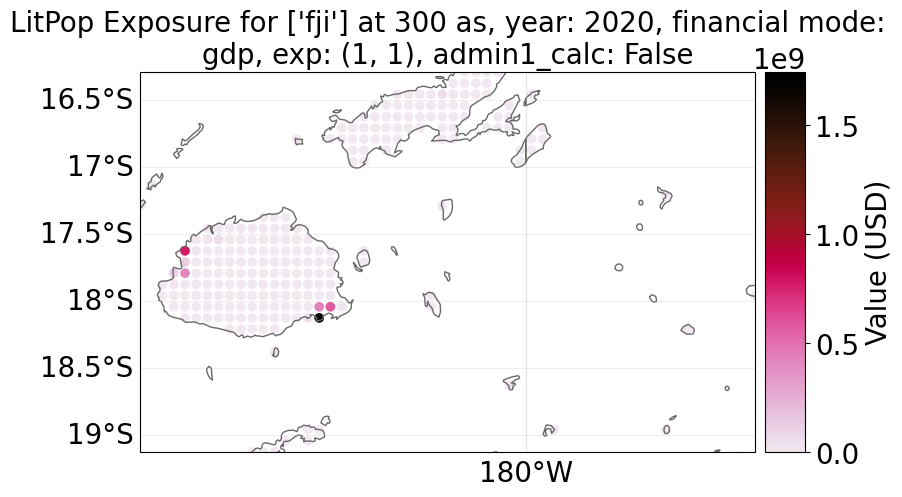

In [20]:
#Generate exposure data
countries = 'fji'
fin_mode = 'gdp'
res_arc = 300
ref_year = 2020

exp = fct.generate_exposure(countries, fin_mode, ref_year, res_arc)

### Generate TC Class

In [21]:
#filter tc tracks which are located close to exposure values
buffer = 0.1

storm_basin_sub = fct.filter_tc_tracks(storms_basin,basins, exp['fji'], buffer)

ax_sub = storm_basin_sub['NA'].plot()
ax_sub.get_legend()._loc = 2

c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:308: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_buffer = exposure.gdf.buffer(distance=buffer, resolution=0)
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\shapely\constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry colu

Number of tracks in NA basin: 0


AttributeError: 'NoneType' object has no attribute 'get_legend'

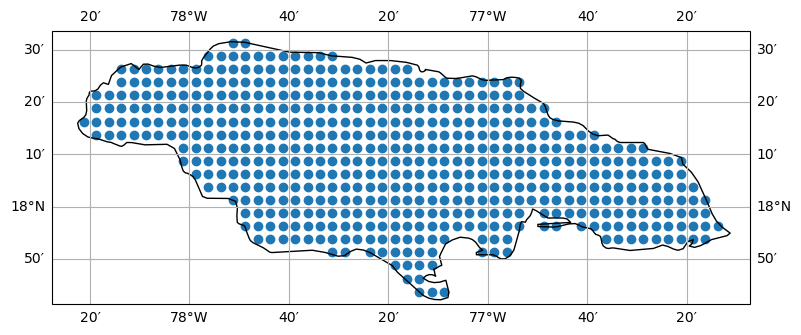

In [5]:
# construct centroids from the exposure position
centrs = fct.construct_centroids(exp_jam_gen)
centrs.plot();

In [6]:
#define frequency correction factor
freq_corr_STORM = 1/1000
#generate tc class
tc_storms = fct.init_tc_hazard(storm_basin_sub, basins, freq_corr_STORM)

In [19]:
exp_jam_gen.gdf.head()

,value,geometry,latitude,longitude,region_id,impf_,if_TC,if_
0,3.144877e+08,POINT (-77.85417 18.52083),18.520833,-77.854167,388,1,1.0,1.0
1,2.531680e+08,POINT (-77.81250 18.52083),18.520833,-77.812500,388,1,1.0,1.0
2,1.429108e+08,POINT (-77.93750 18.47917),18.479167,-77.937500,388,1,1.0,1.0
3,7.719049e+08,POINT (-77.89583 18.47917),18.479167,-77.895833,388,1,1.0,1.0
4,3.816437e+08,POINT (-77.85417 18.47917),18.479167,-77.854167,388,1,1.0,1.0


### Calculate Impact

In [17]:
#import regional calibrated impact function for TC
# prepare impact calcuation - after Samuel Eberenz
# The iso3n codes need to be consistent with the column “region_id” in the 
# 1. Init impact functions:
impact_func_set = trop_cyclone.ImpfSetTropCyclone()
impf_set = impact_func_set.from_calibrated_regional_ImpfSet()
impf_set.check()

# get mapping: country ISO3n per region:
iso3n_per_region = impf_id_per_region = impact_func_set.get_countries_per_region()[2]
    
code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# match exposure with correspoding impact function
for calibration_region in impf_id_per_region:
    for country_iso3n in iso3n_per_region[calibration_region]:
        exp.gdf.loc[exp.gdf.region_id== country_iso3n, 'if_TC'] = code_regions[calibration_region]
    
# calculate impact, save as csv files and write dictionary
imp = ImpactCalc(exp, impact_func_set, tc_storms[basin]).impact(save_mat=True)


NameError: name 'tc_storms' is not defined

In [ ]:
#compute impact
imp = ImpactCalc(exp_jam_gen, impf_set, tc_storm_00).impact(save_mat=True)

In [ ]:
#compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot()
imp.aai_agg
imp_ev = imp.at_event